# Basics of deep learning and neural networks

In this notebook, we will become familiar with the fundamental concepts used in deep learning. We will build simple neural networks and generate predictions with them.

We will be working with networks in order to predict transactions for a bank.

Overview:
1. [Basics of deep learning and neural networks](#Section-1.-Basics-of-deep-learning-and-neural-networks)
1. [The Rectified Linear Activation Function (ReLU)](#Section-2.-The-Rectified-Linear-Activation-Function)
1. [Applying the network to many observations/rows of data](#Section-3.-Applying-the-network-to-many-observations/rows-of-data)
1. [Deeper networks](#Section-4.-Deeper-networks)
1. [The need for optimization](#Section-5.-The-need-for-optimization)
    1. [Calculating the error for one data point](#Subsection-5.1-Calculating-the-error-for-one-data-point)
    1. [Scaling up to multiple data points](#Subsection-5.2-Scaling-up-to-multiple-data-points)
1. [Gradient descent](#Section-6.-Gradient-descent)
1. [Creating a keras model](#Section-7:-Creating-a-keras-model)
    1. [EDA](#Subsection-7.1:-EDA)
    1. [Specifying our model](#Subsection-7.2:-Specifying-our-model)
    1. [Compiling and fitting our model](#Subsection-7.3:-Compiling-and-fitting-our-model)
1. [Classification models](#Section-8.-Classification-models)
1. [Using models](#Section-9.-Using-models)
1. [Understanding model optimization](#Section-10.-Understanding-model-optimization)
1. [Model Validation](#Section-11.-Model-Validation)
    1. [Early stopping: Optimizing the optimization](#Subsection-11.1-Early-stopping:-Optimizing-the-optimization)
    1. [Experimenting with wider networks](#Subsection-11.2:-Experimenting-with-wider-networks)

In [1]:
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Input
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.engine.sequential import Sequential

import pandas as pd
from pandas.core.frame import Series, DataFrame
import numpy as np
from numpy.core import ndarray, int32, float64
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union
import os

Using TensorFlow backend.
C:\Users\YBant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YBant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YBant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YBant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
keras.__version__

'2.2.4'

In [3]:
basedir: str = os.getcwd()

In [4]:
def normabspath(basedir: str, filename: str):
    return os.path.normpath(os.path.join(basedir, filename))

## Section 1. Basics of deep learning and neural networks

We will code a **forward propagation** (prediction) for our first neural network.

Say that each data point is a customer. The first input is how many accounts they have, and the second input is how many children they have. The model will predict **how many transactions the user makes in the next year**. 

In [5]:
# Hard-code input data and weights
num_accounts: int = 3
num_children: int = 5

input_data: ndarray = np.array([num_accounts, num_children])
    
weights: Dict[str, ndarray] = {'node_0': np.array([2, 4]), 
                                  'node_1': np.array([ 4, -5]), 
                                  'output': np.array([2, 7])}

# Calculate the nodes and the output of the neural network
node_0_value: int32 = (input_data * weights['node_0']).sum()

node_1_value: int32 = (input_data * weights['node_1']).sum()

hidden_layer_outputs: ndarray = np.array([node_0_value, node_1_value])

output: int32 = (hidden_layer_outputs * weights['output']).sum()

output

-39

It looks like the network generated a prediction of $-39$ transactions. This number does not make sense as we have to add an activation function as in the next section.

## Section 2. The Rectified Linear Activation Function

An "activation function" is a function applied at each node. It converts the node's input into some output.

The rectified linear activation function (called **ReLU**) has been shown to lead to very high-performance networks. This function takes a single number as an input, returning 0 if the input is negative, and the input if the input is positive.

In [6]:
def relu(input: int32) -> int:
    '''ReLU activation function.'''
    return max(input, 0)

In [7]:
node_0_input: int32 = (input_data * weights['node_0']).sum()
node_0_output: int = relu(node_0_input)

node_1_input: int32 = (input_data * weights['node_1']).sum()
node_1_output: int = relu(node_1_input)

hidden_layer_outputs: ndarray = np.array([node_0_output, node_1_output])

model_output: int32 = (hidden_layer_outputs * weights['output']).sum()

model_output

52

We predicted $52$ transactions. Without this activation function, you would have predicted a negative number ($-39$)! The real power of activation functions will come soon when we start tuning model weights.

## Section 3. Applying the network to many observations/rows of data

You'll now define a function called `predict_with_network()` which will generate predictions for multiple data observations.

In [8]:
def predict_with_network(input_data_row, weights):

    node_0_input = (input_data_row * weights['node_0']).sum()
    node_0_output = relu(node_0_input)

    node_1_input = (input_data_row * weights['node_1']).sum()
    node_1_output = relu(node_1_input)

    hidden_layer_outputs: ndarray = np.array([node_0_output, node_1_output])

    input_to_final_layer = (hidden_layer_outputs * weights['output']).sum()
    model_output = relu(input_to_final_layer)

    return model_output

In [9]:
input_data: List[ndarray] = [np.array([3, 5]),
                                np.array([ 1, -1]),
                                np.array([0, 0]),
                                np.array([8, 4])]

weights: Dict[str, ndarray] = {'node_0': np.array([2, 4]),
                                  'node_1': np.array([ 4, -5]),
                                  'output': np.array([2, 7])}

In [10]:
results: List[int32] = []
for input_data_row in input_data:
    results.append(predict_with_network(input_data_row, weights))

results

[52, 63, 0, 148]

Now, we have predicted the number of transactions for 4 observations (i.e. individuals).

## Section 4. Deeper networks

An important fact about deep networks is that they internally build up representations of the patterns in the data that are useful for making predictions. And they find increasingly complex patterns as we go through successive hidden layers of the network.

Deep learning is also sometimes called **representation learning**, because subsequent layers build increasingly sophiscticated representations of the raw data, until we get to a stage where we can make preditions. In other words, the last layers capture the most complex interactions.

The cool thing about DL is that we do not need to specify the interactions. Instead, the network gets weights that find the relevant patterns to make better predictions. It is the model training process sets them to optimize predictive accuracy.

In [11]:
def predict_with_network(input_data: ndarray, weights):
    """Predicts the number of transactions using a deep network."""
    # Calculate node 0 in the first hidden layer
    node_0_0_input = (input_data * weights['node_0_0']).sum()
    node_0_0_output = relu(node_0_0_input)

    # Calculate node 1 in the first hidden layer
    node_0_1_input = (input_data * weights['node_0_1']).sum()
    node_0_1_output = relu(node_0_1_input)

    # Put node values into a numpy array
    hidden_0_outputs: ndarray = np.array([node_0_0_output, node_0_1_output])
    
    # Calculate node 0 in the second hidden layer
    node_1_0_input = (hidden_0_outputs * weights['node_1_0']).sum()
    node_1_0_output = relu(node_1_0_input)

    # Calculate node 1 in the second hidden layer
    node_1_1_input = (hidden_0_outputs * weights['node_1_1']).sum()
    node_1_1_output = relu(node_1_1_input)

    # Put node values into a numpy array
    hidden_1_outputs = np.array([node_1_0_output, node_1_1_output])

    # Calculate model output
    model_output = (hidden_1_outputs * weights['output']).sum()
    
    return(model_output)

In [12]:
input_data: ndarray = np.array([3, 5])

weights: Dict[str, ndarray] = {'node_0_0': np.array([2, 4]),
                                  'node_0_1': np.array([ 4, -5]),
                                  'node_1_0': np.array([-1,  2]),
                                  'node_1_1': np.array([1, 2]),
                                  'output': np.array([2, 7])}
    
output = predict_with_network(input_data, weights)
print(output)

182


The network generated a prediction of 182 transactions.

## Section 5. The need for optimization

### Subsection 5.1 Calculating the error for one data point

We will now see how we can improve the model accuracy by changing values of weights. For the moment, we won't use an activation function in this example. Or, we can supose that we are using an activation function that returns the input. We call such a function the identity function.

Let's say that the **true value of the target** is 3. So, the closer our prediction is to 3, the more accurate the model is for this data point.

We will use **forward propagation** to fill in the values of the hidden layer.

The **error** can be computes as follows: $$ \text{Error} = \text{Predicted target value} - \text{Actual target value}. $$

In [13]:
def predict_with_network(input_data_point: ndarray, weights: Dict[str, List[int]]) -> float64:
    node_0_input = (input_data_point * weights['node_0']).sum()
    node_0_output = relu(node_0_input)

    node_1_input = (input_data_point * weights['node_1']).sum()
    node_1_output = relu(node_1_input)

    hidden_layer_values = np.array([node_0_output, node_1_output])
    input_to_final_layer = (hidden_layer_values * weights['output']).sum()
    model_output = relu(input_to_final_layer)
    
    return(model_output)

In [14]:
input_data: ndarray = np.array([0, 3])

# Sample weights
weights_0: Dict[str, List[int]] = {'node_0': [2, 1],
                                   'node_1': [1, 2],
                                   'output': [1, 1]}

# The actual target value, use to calculate the error
target_actual: int = 3

# Make prediction using original weights
model_output_0: List[float64] = predict_with_network(input_data, weights_0)

# Calculate error
error_0 = model_output_0 - target_actual

# Create weights that cause the network to make perfect prediction (3)
weights_1 = {'node_0': [2, 1],
             'node_1': [1, 0],
             'output': [1, 1]}

# Make prediction using new weights
model_output_1: List[float64] = predict_with_network(input_data, weights_1)

# Calculate the new error
error_1: int32 = model_output_1 - target_actual

print(error_0)
print(error_1)

6
0


### Subsection 5.2 Scaling up to multiple data points

We've seen how different weights will have different accuracies on a single prediction. But usually, we'll want to measure model accuracy on many points. 

We'll compare model accuracies for two different sets of weights:

In [15]:
weights_0: Dict[str, ndarray] = {'node_0': np.array([2, 1]), 
                                    'node_1': np.array([1, 2]), 
                                    'output': np.array([1, 1])}

weights_1: Dict[str, ndarray] = {'node_0': np.array([2, 1]),
                                    'node_1': np.array([1. , 1.5]),
                                    'output': np.array([1. , 1.5])}

`input_data` is a list of arrays. Each item in that list contains the data to make a single prediction. 

`target_actuals` is a list of numbers. Each item in that list is the actual value we are trying to predict.

In [16]:
input_data: List[ndarray] = [np.array([0, 3]), 
                                np.array([1, 2]), 
                                np.array([-1, -2]), 
                                np.array([4, 0])]

target_actuals: List[int] =  [1, 3, 5, 7]

We'll use the `mean_squared_error()` function from `sklearn.metrics`. It takes the true values and the predicted values as arguments.

In [17]:
model_output_0: List[int32] = []
model_output_1: List[int32] = []

for row in input_data:
    model_output_0.append(predict_with_network(row, weights_0))
    model_output_1.append(predict_with_network(row, weights_1))

mse_0: float = mean_squared_error(target_actuals, model_output_0)
mse_1: float = mean_squared_error(target_actuals, model_output_1)

print(f"Mean squared error with weights_0: {mse_0:.2f}")
print(f"Mean squared error with weights_1: {mse_1:.2f}")

Mean squared error with weights_0: 37.50
Mean squared error with weights_1: 49.89


It looks like `model_output_1` has a higher mean squared error.

## Section 6. Gradient descent

With gradient descent we repeatedly find a slope capturing how our loss function, $\text{Loss}(\omega)$, changes as a weight changes. We then do a small change to the weight to get to a lower point, and we repeat this process until we couldn't go downhill anymore.

If the slope is positive, going opposite to the slope means moving to lower numbers. How do we achieve this? Subtracting the slope from the current value. But a too big step might lead us astray. Thus, instead of directly subtracting the slope, we multiply the slope by a small number, called the **learning rate**, and we update the weight by the product of that multiplication: $$ \text{Updated weights} = \text{weights} - \text{slope} \times \text{learning rate}. $$

We typically use a learning rate of $0.01$. This ensures that we take small steps, such that we reliably move towards the optimal weights.

How do we find the relevant slope for each weight we need to update? Remember the chain rule of calculus... To calculate the slope for a weight, we need to multiply:
1. The slope of the loss function wrt the value at the node we feed
1. The value of the node that feeds into our weight
1. The slope of the activation function wrt the value we feed into

Let's put away the last point for a moment. The slope of the Mean-Squared loss function wrt to the prediction can be written as follows: $$2\times\text{Error}$$ where $\text{error} = \text{Predicted value} - \text{Actual value}$ as aforementioned.

In [18]:
def get_error(input_data: ndarray, target: int, weights: ndarray) -> int32:
    preds: int32 = (weights * input_data).sum()
    error: int32 = preds - target
    return error

In [19]:
def get_slope(input_data: ndarray, target: int, weights: ndarray) -> ndarray:
    error: int32 = get_error(input_data, target, weights)
    slope: ndarray = 2 * input_data * error
    return slope

In [20]:
def get_mse(input_data: ndarray, target: int, weights: ndarray) -> float64:
    errors: int32 = get_error(input_data, target, weights)
    mse: float64 = np.mean(errors**2)
    return mse

In [21]:
input_data: ndarray = np.array([1, 2, 3])
target: int = 0
weights: ndarray = np.array([0, 2, 1])

In [22]:
n_updates: int = 20
learning_rate: float = 0.01
mse_hist: List[float64] = []

# Iterate over the number of updates
for i in range(n_updates):
    # Calculate the slope
    slope: ndarray = get_slope(input_data, target, weights)

    # Update the weights
    weights: ndarray = weights - slope * learning_rate

    # Calculate MSE with new weights
    mse: float64 = get_mse(input_data, target, weights)
    mse_hist.append(mse)

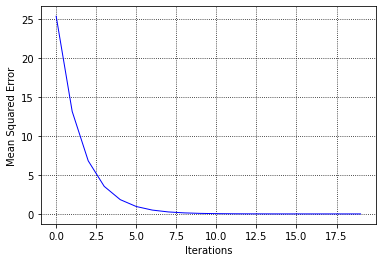

In [23]:
plt.plot(mse_hist, c='b', lw=1)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.grid(True, c='k', ls=':')
plt.show()

 As we can see, the mean-squared error decreases as the number of iterations goes up.

## Section 7: Creating a keras model

The Keras workflow has 4 steps:
1. Specify the architecture
    1. How many layers?
    1. How many nodes in each layer?
    1. What activation function to use in each layer?
1. Compile the model
    * This specifies the loss function, and
    * The optimization solver to use
1. Fit the model
1. Make predictions


### Subsection 7.1: EDA
We will soon start building models in Keras to predict wages based on various professional and demographic factors. Before we start building a model, it's good to understand our data by performing some exploratory analysis (EDA).

The target variable we'll be predicting is `wage_per_hour`. Some of the predictor variables are binary indicators, where a value of `1` represents `True`, and `0` represents `False`.

In [24]:
data = pd.read_csv('data/hourly_wages.csv')
data.head(3)

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,0,8,21,35,1,1,0,1,0
1,4.95,0,9,42,57,1,1,0,1,0
2,6.67,0,12,1,19,0,0,0,1,0


Of the 9 predictor variables in the DataFrame, how many are binary indicators? The `min` and `max` values as shown by `.describe()` will be informative here. So, how many binary indicator predictors are there? We can observe that there are 6 binary predictors.

In [25]:
data.describe().round(1)

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
count,534.0,534.0,534.0,534.0,534.0,534.0,534.0,534.0,534.0,534.0
mean,9.0,0.2,13.0,17.8,36.8,0.5,0.7,0.3,0.2,0.0
std,5.1,0.4,2.6,12.4,11.7,0.5,0.5,0.5,0.4,0.2
min,1.0,0.0,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
25%,5.2,0.0,12.0,8.0,28.0,0.0,0.0,0.0,0.0,0.0
50%,7.8,0.0,12.0,15.0,35.0,0.0,1.0,0.0,0.0,0.0
75%,11.2,0.0,15.0,26.0,44.0,1.0,1.0,1.0,0.0,0.0
max,44.5,1.0,18.0,55.0,64.0,1.0,1.0,1.0,1.0,1.0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wage_per_hour   534 non-null    float64
 1   union           534 non-null    int64  
 2   education_yrs   534 non-null    int64  
 3   experience_yrs  534 non-null    int64  
 4   age             534 non-null    int64  
 5   female          534 non-null    int64  
 6   marr            534 non-null    int64  
 7   south           534 non-null    int64  
 8   manufacturing   534 non-null    int64  
 9   construction    534 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 41.8 KB


### Subsection 7.2: Specifying our model

Now we'll get to work with our first model in Keras, and will immediately be able to run more complex neural network models on larger datasets.

To start, we'll take the skeleton of a neural network and add a hidden layer and an output layer. We'll then fit that model and see Keras do the optimization so our model continually gets better.

As a start, we'll predict workers wages based on characteristics like their industry, education and level of experience. For convenience, everything in `data` except for the target has been converted to a NumPy matrix called `predictors`. The target, `wage_per_hour`, is assigned to a NumPy matrix called `target`.

In [27]:
predictors: ndarray = data.drop('wage_per_hour', axis=1).to_numpy()
target: ndarray = data.wage_per_hour.to_numpy()
    
n_cols: int = predictors.shape[1]

model = Sequential()

# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))

# Add the second layer
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


### Subsection 7.3: Compiling and fitting our model

Now that we've specified the model, the next step is to compile it, which sets up the network for optimization. For instance, creating an internal function to do back-propagation efficiently.

The compile method has 2 important arguments for us to choose:
1. What optimizer to use (which controls the learning rate)?
    * In practice, the right choice of learning rate can make a huge difference for how quickly our model finds good weights, and even how good a set of weights it can find.
    * There are a few algorithms that automatically tune the learning rate. Even many experts in the field don't know all the details of all the optimization algorithms. Therefore, the pragmatic approach is to choose a versatile algorithm and use that for most problems. In that sense, "Adam" is an excellent choice as out go-to optimizer. "Adam" adjusts the learning rate as it does gradient descent to ensure reasonable values throughout the weight optimization process.
1. What loss function to use?
    * `'mean_squared_error'` is the most common choice for regression problems. However, when we use keras for classification, we will use a new default metric.
    
You can read more about the Adam optimizer as well as other keras optimizers [here](https://keras.io/api/optimizers/#adam), and if you are really curious to learn more, you can read the [original paper](https://arxiv.org/abs/1412.6980v8) that introduced the Adam optimizer.

In [28]:
model.compile(optimizer="adam", loss="mean_squared_error")
print(f'Loss function: {model.loss!r}')

Loss function: 'mean_squared_error'


After we have compiled our model, we can fit it. That is, applying back-propagation and gradient descent with our data to update the weights.

The fit step looks similar to the scikit-learn's one, though it has more options which we will explore soon.

Even with the "Adam" optimizer, wich is pretty smart, it can improve our optimization process if we scale all the data such that each feature is, on average, about similar sized values. One common approach is to subtract each feature by that feature's mean, and divide it by it's standard deviation. This process is called normalization: $$ z = \frac{x -\mu}{\sigma} $$

In [29]:
model.fit(predictors, target)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
534/534 [==============================] - 0s 408us/step - loss: 26.2446


## Section 8. Classification models

For classification, we do a couple of things differently.

The biggest changes are:
1. Set the loss function as `'categorical_crossentropy'` instead of `'mean_squared_error'`. This isn't the only possible loss function for classification problems, but it is by far the most common. For a **categorical crossentropy loss function**, a **lower score is better**. But it is still hard to interpret. Therefore, we can add `metrics = ['accuracy']` to the compile sten for easy-to-understand diagnostics.
1. Modify the last layer such that is has a separate note for each potential outcome. We also change the activation function to `'softmax'`. The softmax activation function ensures the predictions sum to 1 such that they can be interpreted like probabilities.

Now we will start modeling with a new dataset for a classification problem. This data includes information about passengers on the Titanic. We will use predictors such as `age`, `fare` and where each passenger embarked from to predict who will survive. This data is from a [kaggle tutorial](https://www.kaggle.com/c/titanic). Look [here](https://www.kaggle.com/c/titanic/data) for descriptions of the features.

In [30]:
titanic_filepath: str = normabspath(basedir, 'data/titanic_all_numeric.csv')
titanic: DataFrame = pd.read_csv(titanic_filepath)
titanic.head()

,survived,pclass,age,sibsp,parch,fare,male,age_was_missing,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton
0,0,3,22.0,1,0,7.2500,1,False,0,0,1
1,1,1,38.0,1,0,71.2833,0,False,1,0,0
2,1,3,26.0,0,0,7.9250,0,False,0,0,1
3,1,1,35.0,1,0,53.1000,0,False,0,0,1
4,0,3,35.0,0,0,8.0500,1,False,0,0,1


In [31]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   survived                   891 non-null    int64  
 1   pclass                     891 non-null    int64  
 2   age                        891 non-null    float64
 3   sibsp                      891 non-null    int64  
 4   parch                      891 non-null    int64  
 5   fare                       891 non-null    float64
 6   male                       891 non-null    int64  
 7   age_was_missing            891 non-null    bool   
 8   embarked_from_cherbourg    891 non-null    int64  
 9   embarked_from_queenstown   891 non-null    int64  
 10  embarked_from_southampton  891 non-null    int64  
dtypes: bool(1), float64(2), int64(8)
memory usage: 70.6 KB


It's smart to review the maximum and minimum values of each variable to ensure the data isn't misformatted or corrupted. What was the maximum age of passengers on the Titanic? 

In [32]:
titanic.describe().round(1)

,survived,pclass,age,sibsp,parch,fare,male,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,0.4,2.3,29.7,0.5,0.4,32.2,0.6,0.2,0.1,0.7
std,0.5,0.8,13.0,1.1,0.8,49.7,0.5,0.4,0.3,0.4
min,0.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,2.0,22.0,0.0,0.0,7.9,0.0,0.0,0.0,0.0
50%,0.0,3.0,29.7,0.0,0.0,14.5,1.0,0.0,0.0,1.0
75%,1.0,3.0,35.0,1.0,0.0,31.0,1.0,0.0,0.0,1.0
max,1.0,3.0,80.0,8.0,6.0,512.3,1.0,1.0,1.0,1.0


In [33]:
target: ndarray = to_categorical(titanic.survived)
predictors: ndarray = titanic.drop('survived', axis=1).to_numpy()
n_cols: int = predictors.shape[1]
    
# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(32, activation='relu', input_shape=(n_cols, )))

# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(predictors, target)

Epoch 1/1
891/891 [==============================] - 0s 174us/step - loss: 3.7173 - acc: 0.5735


This simple model is generating an accuracy greater than 60%!

## Section 9. Using models

The usual workflow associated with deep learning models is:
1. Save the model after you have trained it
1. Reload the model
1. Make prediction with the model

In [34]:
model_filepath: str = normabspath(basedir, 'models/classification_model.h5')
    
# Save the model
model.save(model_filepath)

# Load the model back into memory
my_model: Sequential = load_model(model_filepath)

# Make predictions (they come in the same format as the prediction target, here 2 columns)
predictions: ndarray = my_model.predict(predictors)
    
# Individuals who would survive on the Titanic
probability_true = predictions[:, 1]

# Summary of the model architecture
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 418
Trainable params: 418
Non-trainable params: 0
_________________________________________________________________


## Section 10. Understanding model optimization

It's time to get our hands dirty with optimization. We'll now try optimizing a model at a very low learning rate, a very high learning rate, and a "just right" learning rate. We'll want to look at the output after running the code, remembering that a low value for the loss function is good.

We will use the predictors and target from section 9.

In [35]:
def get_new_model(input_shape: Tuple[Union[None, int], Union[None, int]]) -> Sequential:
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

In [36]:
learning_rates_to_test: Tuple[int, int, int] = (.000001, .01, 1)

for lr in learning_rates_to_test:
    print(f"\n\nTesting model with learning rate: {lr}")
    model = get_new_model(input_shape=(n_cols, ))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    model.fit(predictors, target)



Testing model with learning rate: 1e-06
Epoch 1/1
891/891 [==============================] - 0s 212us/step - loss: 2.9453


Testing model with learning rate: 0.01
Epoch 1/1
891/891 [==============================] - 0s 227us/step - loss: 2.2020


Testing model with learning rate: 1
Epoch 1/1
891/891 [==============================] - 0s 305us/step - loss: 6.1532


As we can see from above, the lowest value for the loss function (categorical crossentropy) is achieved by the middle learning rate 0.01. Worst case is achieved utilizing a learning rate equal to 1.

## Section 11. Model Validation


In [37]:
model = get_new_model(input_shape=(n_cols, ))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(predictors, target, validation_split=.3)

Train on 623 samples, validate on 268 samples
Epoch 1/1
623/623 [==============================] - 0s 630us/step - loss: 1.1831 - acc: 0.5778 - val_loss: 0.9052 - val_acc: 0.6157


### Subsection 11.1 Early stopping: Optimizing the optimization

Now that we know how to monitor our model performance throughout optimization, we can use early stopping to stop optimization when it isn't helping any more. Since the optimization stops automatically when it isn't helping, we can also set a high value for epochs in our call to `.fit()`.

In [38]:
input_shape: Tuple[int] = (n_cols, )
model = get_new_model(input_shape=input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

model.fit(predictors, target, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 623 samples, validate on 268 samples
Epoch 1/30
623/623 [==============================] - 0s 614us/step - loss: 1.1365 - acc: 0.5843 - val_loss: 0.7179 - val_acc: 0.7276
Epoch 2/30
623/623 [==============================] - 0s 36us/step - loss: 0.6876 - acc: 0.6822 - val_loss: 0.5348 - val_acc: 0.7575
Epoch 3/30
623/623 [==============================] - 0s 38us/step - loss: 0.6558 - acc: 0.6645 - val_loss: 0.5231 - val_acc: 0.7612
Epoch 4/30
623/623 [==============================] - 0s 40us/step - loss: 0.6392 - acc: 0.6886 - val_loss: 0.6280 - val_acc: 0.7313
Epoch 5/30
623/623 [==============================] - 0s 43us/step - loss: 0.6442 - acc: 0.6838 - val_loss: 0.5290 - val_acc: 0.7649


Because optimization will automatically stop when it is no longer helpful, it is okay to specify the maximum number of epochs as 30 rather than using the default of 10 that we've used so far.

### Subsection 11.2: Experimenting with wider networks

Now we know everything we need to begin experimenting with different models!

Here, we will compare two models. `model_2` will be similar to `model_1`, except it will have 100 units in each hidden layer instead of 10.

In [39]:
def create_model(num_nodes: int,
                 input_shape: Tuple[Union[None, int], Union[None, int]],
                 num_layers: int = 2) -> Sequential:
    '''Create a Sequential models.
    '''
    model = Sequential()
    
    if num_layers < 1:
        raise ValueError(f'You have to provide 1 layer at least! You provided {num_layers} instead.')
    elif num_layers == 1:
        model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))
    elif num_layers > 1:
        model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))
        for i in range(num_layers - 1):
            model.add(Dense(num_nodes, activation='relu'))

    # Add the output layer
    model.add(Dense(2, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [40]:
model_1 = create_model(num_nodes=10, input_shape=input_shape)
model_2 = create_model(num_nodes=100, input_shape=input_shape)

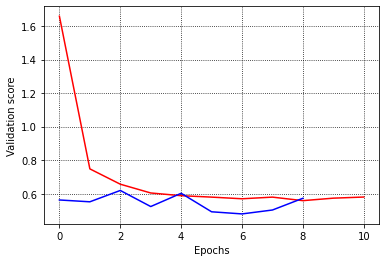

In [41]:
# Fit model_1
model_1_training = model_1.fit(predictors, target, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Fit model_2
model_2_training = model_2.fit(predictors, target, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.grid(True, c='k', ls=':')
plt.show()

The blue model has a lower loss value, so it is the better model.

We have seen how to experiment with wider networks. Below, we'll try a deeper network (i.e., more hidden layers).

Once again, we will create a baseline model called `model_a` as a starting point. It has 1 hidden layer, with 50 units. We will create a similar network with 3 hidden layers (still keeping 50 units in each layer).

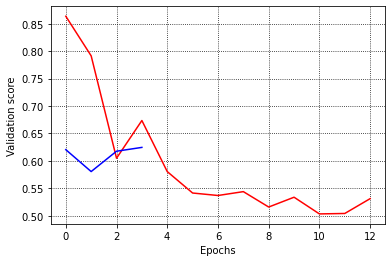

In [42]:
model_a: Sequential = create_model(num_nodes=50, input_shape=input_shape, num_layers=1)
model_b: Sequential = create_model(num_nodes=50, input_shape=input_shape, num_layers=3)

model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_a_training = model_a.fit(predictors, target, epochs=20, validation_split=0.4, 
                               callbacks=[early_stopping_monitor], verbose=False)
model_b_training = model_b.fit(predictors, target, epochs=20, validation_split=0.4, 
                               callbacks=[early_stopping_monitor], verbose=False)

plt.plot(model_a_training.history['val_loss'], 'r', model_b_training.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.grid(True, c='k', ls=':')
plt.show()